In [11]:
import pandas as pd
import numpy as np
import math
import statistics
import datetime as dt
from matplotlib import pyplot as plt

from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import train_test_split

from sksurv.datasets import load_breast_cancer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from collections import Counter

import imblearn

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('imputedReadmission.csv')
df = df.drop(axis=1, columns=['Unnamed: 0'], inplace=False)

#cleaning

colCats = {
    'admInfo': ['subject_id', 'hadm_id', 'stay_id'],
    'ptInfoCont': ['age', 'height', 'weight'],
    'demographics': ['gender','ethnicity','marital_status','insurance','language'],
    'admCat': ['first_careunit','last_careunit','admission_location','admission_type', 'dbsource'],
    'admTime': ['admittime', 'dischtime', 'intime', 'outtime', 'reint_time', 'ext_time', 'postop_intime', 'deathtime', 'dod'],
    'admNum': ['los','icustay_seq'],
    'markersTs': ['aki', 'ph', 'bicarb', 'baseexcess', 'chloride', 'free_calcium', 'glucose', 'potassium', 'sodium', 'lactate', 
                  'hematocrit', 'hb', 'pco2', 'po2', 'bg_temp', 'fio2', 'ventrate', 'tidalvol', 'aado2', 'specimen', 'neutrophils', 
                  'lymphocytes', 'wcc', 'plt', 'crp', 'albumin', 'creatinine', 'bun', 'magnesium', 'alt', 'alp', 'ast', 'ggt', 
                  'bilirubin_total', 'bilirubin_direct', 'bilirubin_indirect', 'inr', 'fibrinogen', 'bleed_time', 'ptt', 'pt', 'hba1c', 'prbc', 'plts', 'ffp', 'cryo'],
    'procedureType': ['aortic','mitral','tricuspid','pulmonary','cabg'],
    'comorbids': ['liver_severe','liver_mild','rheum','cvd','aids','ckd','copd','arrhythmia','pud','smoking','pvd',
                      'paraplegia','ccf','met_ca','t2dm','t1dm','malig','mi','dementia'],
    'diabUnits': ['diab_un', 'diab_cc'],
    'otherTs': ['dtoutput', 'echo', 'fluid', 'infection', 'intropes', 'insulin', 'pasp', 'padp', 'mpap', 'vent_array'],
    'vitalsTs': ['hr', 'sbp', 'dbp', 'meanbp', 'rr', 'temp', 'spo2', 'cardiac_index'],
    'misc': ['sofa', 'reintubation'],
    'readmitInfo': ['readmit_times', 'readmissions', 'first_readmission'],
    'ventTimes': ['int_time1', 'ext_time1', 'duration1', 'int_time2', 'ext_time2', 'duration2'],
    'icuStayInfo': ['icu_stay_hrs']
}
colCatsSquashed = [j for k in [colCats[i] for i in colCats] for j in k]

In [3]:
data_x = df[[i for i in df.columns if i not in [*colCats['readmitInfo'], *colCats['admTime'], *colCats['admInfo'], 
                                                'int_time1', 'ext_time1', 'int_time2', 'ext_time2', 'duration1', 'duration2', 'icustay_seq',
                                                't1dm', 't2dm', 'los'] and '_min' not in i and '_max' not in i]]
print(data_x.columns.to_list())

for i in data_x.columns:
    if data_x[i].dtype == 'object':
        data_x[i] = data_x[i].astype('category')

data_y = (~pd.isnull(df['first_readmission'])).astype(int)
data_y = np.array(data_y, dtype=np.int32)

data_x_numeric = OneHotEncoder().fit_transform(data_x)

['ph_mean', 'bicarb_mean', 'baseexcess_mean', 'chloride_mean', 'free_calcium_mean', 'glucose_mean', 'potassium_mean', 'sodium_mean', 'lactate_mean', 'hematocrit_mean', 'hb_mean', 'pco2_mean', 'po2_mean', 'wcc_mean', 'plt_mean', 'creatinine_mean', 'bun_mean', 'magnesium_mean', 'inr_mean', 'ptt_mean', 'hba1c_mean', 'prbc_mean', 'hr_mean', 'sbp_mean', 'dbp_mean', 'meanbp_mean', 'rr_mean', 'temp_mean', 'spo2_mean', 'cardiac_index_mean', 'dtoutput_mean', 'pasp_mean', 'padp_mean', 'mpap_mean', 'abx_no', 'abx_bool', 'aki_stage_creat_mean', 'aki_stage_uo_mean', 'age', 'gender', 'ethnicity', 'height', 'weight', 'admission_type', 'admission_location', 'insurance', 'marital_status', 'language', 'first_careunit', 'last_careunit', 'dbsource', 'sofa', 'cabg', 'aortic', 'mitral', 'tricuspid', 'pulmonary', 'mi', 'arrhythmia', 'ccf', 'pvd', 'cvd', 'dementia', 'copd', 'rheum', 'pud', 'liver_mild', 'paraplegia', 'ckd', 'malig', 'liver_severe', 'met_ca', 'aids', 'smoking', 'reintubation', 'icu_stay_hrs']


C:\Users\zhepu\AppData\Local\Temp/ipykernel_49560/2554848101.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_x[i] = data_x[i].astype('category')


In [51]:
x_train, x_test, y_train, y_test = train_test_split(data_x_numeric, data_y, test_size=0.2, random_state=20)

oversample = SMOTE(sampling_strategy=0.5)
undersample = RandomUnderSampler(sampling_strategy=0.6)
steps = [('o', oversample), ('u', undersample)]
pipeline = Pipeline(steps=steps)
x_smote, y_smote = pipeline.fit_resample(x_train, y_train)

counter = Counter(y_smote)
print(counter)
print(Counter(y_test))

clf = LogisticRegression(random_state=0, max_iter=1000).fit(x_smote, y_smote)
print('Score', clf.score(x_test, y_test))

z = clf.predict_proba(x_test)[:,0]<0.7

a = sum((z == y_test)[y_test==1]) #tp
b = sum((z != y_test)[y_test==1]) #fn
c = sum((z == y_test)[y_test==0]) #tn
d = sum((z != y_test)[y_test==0]) #fp

print('Sensitivity TPR', a/(a+b))
print('Specificity TNR', c/(c+d))
print('PPV', a/(a+d))
print('NPV', c/(c+b))
print('Total positive', (a+d)/(a+b+c+d))

Counter({0: 4156, 1: 2494})
Counter({0: 1255, 1: 57})
Score 0.885670731707317
Sensitivity TPR 0.5263157894736842
Specificity TNR 0.7920318725099602
PPV 0.10309278350515463
NPV 0.9735553379040157
Total positive 0.22179878048780488


c:\users\zhepu\desktop\trident\jahan\tridentenv\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic: ROC AUC=0.717


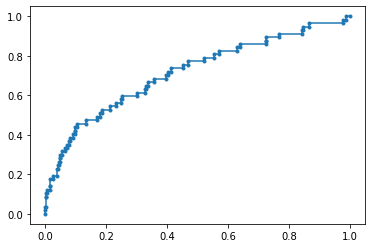

In [18]:
lr_probs = clf.predict_proba(x_test)[:,1]
lr_auc = roc_auc_score(y_test, lr_probs)
print('Logistic: ROC AUC=%.3f' % (lr_auc))
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

plt.show()